<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Larissa_Santesso/entrega_01/CNN_T5_wandb_exp002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wandb

In [ ]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 33.6 MB/s 
     |████████████████████████████████| 181 kB 64.6 MB/s 
     |████████████████████████████████| 145 kB 72.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config_wandb={
        "learning_rate": 3e-4,
        "batch_size": 30,
        "architecture": "CNN + T5-small",
        "dataset": "MS-COCO 23k",
        "epochs": 50,
        "eval_epochs": 1,
        "max_seq_length": 32,
        "decoder_pretrained_model": "google/t5-efficient-small-dm768",
        "path_save_model":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/modelos/model_CNN_T5_wandb_exp002.pt",
        "path_save_checkpoints":  "/content/gdrive/MyDrive/Colab Notebooks/Projeto/checkpoints/",
        "checkpoint_folder_name": "checkpoint_CNN_T5_002.tar"

}


run = "002"

run_id = None
# run_id = '33cxkjty'

# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 28.2 MB/s 


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 37.3 MB/s 
     |████████████████████████████████| 596 kB 60.4 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 6.6 MB 60.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 5.5 MB/s 


In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
from transformers import T5ForConditionalGeneration, T5Tokenizer
from matplotlib import pyplot as plt
import math
import random
import numpy as np
import h5py, json
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import collections
import itertools
import functools
from tqdm.notebook import tqdm

from sacrebleu.metrics import BLEU 

In [ ]:
# Check which GPU we are using
!nvidia-smi

Wed Jun 29 13:45:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Dataset: MS-COCO

## Download do dataset reduzido

In [ ]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-29 20:30:44--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4624222304 (4.3G) [application/octet-stream]
Saving to: ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’

TRAIN_IMAGES_coco_5 100%[===================>]   4.31G  74.2MB/s    in 23s     

2022-06-29 20:31:08 (192 MB/s) - ‘TRAIN_IMAGES_coco_5_cap_per_img.hdf5’ saved [4624222304/4624222304]

--2022-06-29 20:31:08--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connect

In [ ]:
ls

gdrive/                                 TRAIN_IMAGES_coco_5_cap_per_img.hdf5
sample_data/                            VAL_CAPTIONS_coco_5_cap_per_img.json
TEST_IMAGES_coco_5_cap_per_img.hdf5     VAL_IMAGES_coco_5_cap_per_img.hdf5
TRAIN_CAPTIONS_coco_5_cap_per_img.json


## Download do dataset completo

Em construção

## Construindo CocoDataset `class`


In [ ]:
class CocoDataset():
    def __init__(self, transform=None, mode_dataset = 'TRAIN'):
        
        self.transform = transform

        self.imgs = h5py.File(str(mode_dataset)+'_IMAGES_coco_5_cap_per_img.hdf5', 'r')
        self.imgs = self.imgs['images']
        self.captions = json.load(open(str(mode_dataset)+'_CAPTIONS_coco_5_cap_per_img.json'))

        assert len(self.imgs) == len(self.captions)

    def __len__(self):  
        return len(self.captions)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        caption = self.captions[idx]

        #if self.random_caption==True:
        #    caption = random.choice(caption) 
        
        if self.transform is not None:
            img = self.transform(np.transpose(np.copy(img), (1, 2, 0)))

        return img, caption

In [ ]:
transform_img = transforms.Compose([
    transforms.ToTensor(),         # convert the PIL Image to a tensor
    transforms.Resize(size = (224,224)),
    #transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

tokenizer = T5Tokenizer.from_pretrained(config_wandb["decoder_pretrained_model"])

train_dataset = CocoDataset(transform = transform_img)
val_dataset = CocoDataset(transform = transform_img, mode_dataset='VAL')
#test_dataset = CocoDataset(tokenizer = tokenizer, transform = transform_img, mode_dataset='TEST') ## não tem captions!!!

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# Modelo


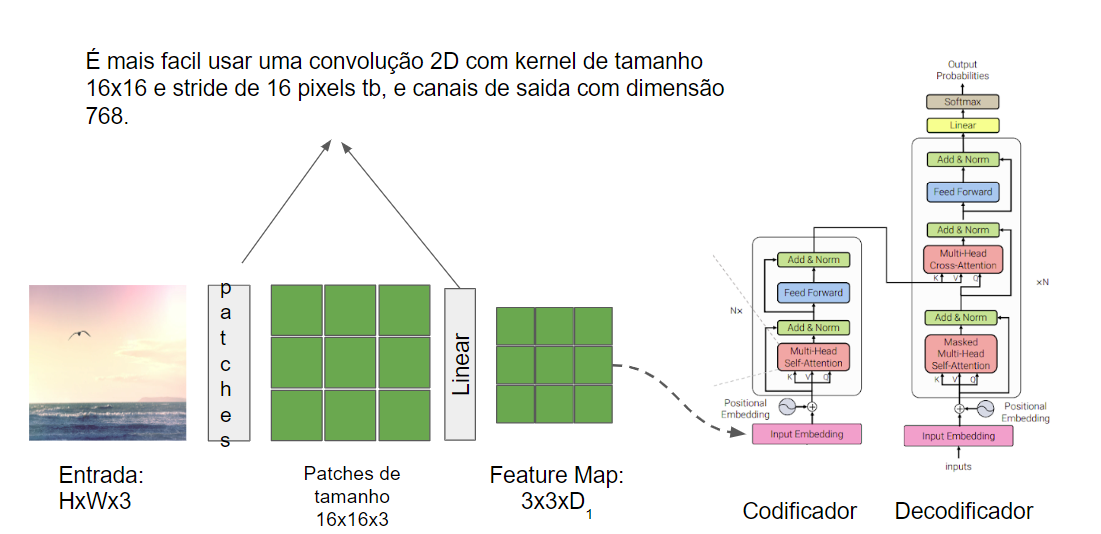

## Decoder T5


https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration

https://huggingface.co/docs/transformers/v4.19.4/en/main_classes/output#transformers.modeling_outputs.Seq2SeqLMOutput

https://huggingface.co/blog/how-to-generate

In [ ]:
def collate_custom(batch):
    """
    Input any (selected randomly) caption sample for every image. Useful for training.
    """
    
    imgs = [r[0] for r in batch]
    texts = [r[1] for r in batch] # all captions (5) of each image -- purpose: calculus of NLP metrics
    text = [random.choice(r[1]) for r in batch] # one random caption of each image -- purpose: for training

    batch_tokens = tokenizer.batch_encode_plus(text, return_tensors="pt",  padding='longest')

    return (
        torch.stack(imgs), 
        batch_tokens["input_ids"], 
        texts,
    )

In [ ]:
class CNNT5Model(torch.nn.Module):

    def __init__(self, tokenizer, pretrained_model, max_seq_length=32, img_size = (224,224), patches_size=16, n_channels = 3, input_dimTransformer = 768):
        """
        Implements the Self-attention, decoder-only."

        Args:
            vocab_size (int): Size of the input vocabulary.
            max_seq_length (int): Size of the sequence to consider as context for prediction.
            dim (int): Dimension of the embedding layer for each word in the context.
            n_layers (int): number of self-attention layers.
            pad_token_id (int): id of the pad token that will be ignored in the attention.
        """
        super(CNNT5Model, self).__init__()

        self.max_seq_length = max_seq_length
        self.pad_token_id = tokenizer.pad_token_id
        self.eos_token_id = tokenizer.eos_token_id
        
        self.img_size = img_size
        self.n_channels = n_channels
        self.embed_size = input_dimTransformer

        # Initializing CNN for creation of patches
        self.cnn_pacthes = nn.Conv2d(self.n_channels, self.embed_size, kernel_size=(patches_size, patches_size), stride=(patches_size, patches_size))
        self.transformer = T5ForConditionalGeneration.from_pretrained(pretrained_model)
        self.transformer.config.eos_token_id = tokenizer.eos_token_id
        self.transformer.config.pad_token_id = tokenizer.pad_token_id
        self.decoder_start_token_id = self.transformer.config.decoder_start_token_id
        # Embedding of the pactches
        self.embeddings_P = nn.Embedding((img_size[0]//patches_size)*(img_size[1]//patches_size), self.embed_size)
        #print(self.embeddings_P.weight.shape)
        self.dropout = nn.Dropout(p=0.1)

    def creating_patches_from_images(self, inputs):
        out_patches = self.cnn_pacthes(inputs).permute(0, 2, 3, 1) #.view(B,input_dimTransformer,H//patches_size*W//patches_size)
        out_patches  = out_patches .reshape(out_patches.shape[0], -1, self.embed_size)
        out_patches+=self.embeddings_P.weight
        #out_patches = self.dropout(out_patches)

        return out_patches

    def forward(self, images = None, targets = None, decoder_ids = None):

        out = self.creating_patches_from_images(images)
        
        if decoder_ids is not None:
            out = self.transformer(inputs_embeds=out, decoder_input_ids=decoder_ids)
        
        # training
        else:
            out = self.transformer(inputs_embeds=out, labels=targets)
            
        return out

In [ ]:
model = CNNT5Model(tokenizer, config_wandb["decoder_pretrained_model"])

Downloading:   0%|          | 0.00/635 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Número de parâmetros do modelo: {num_params}')

Número de parâmetros do modelo: 91500800


# Treinamento

Downloading:   0%|          | 0.00/635 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A cat is sitting on a bed with a stuffed animal.', 'A cat is sitting on a chair with a stuffed animal. a dog', 'A man is riding a horse in a field. a man is riding a horse in the', 'A cat is sitting on a chair with a stuffed animal.', 'A man is riding a horse on a beach. a dog is laying on', 'A man is riding a horse in a field. a dog is laying on a bench.', 'A man is riding a horse in a field. a man is riding', 'A man is riding a horse in a field. a dog is laying on', 'A man riding a horse on a beach with a dog. a dog on a beach with', 'A dog is standing on a grassy field. a zebra standing on a grassy field with', 'A dog is standing on a bench next to a tree. a ze', 'A man riding a horse in a field with a dog. a dog on a', 'A cat is sitting on a bed with a stuffed animal.', 'A cat is sitting on a bed with a stuffed animal. a cat sitting on', 'A cat is sitting on a bed with a stuffed animal. a', 'A cat is sitting on a chair with a stuffed animal. a', 'A cat is sitting on a chair with 

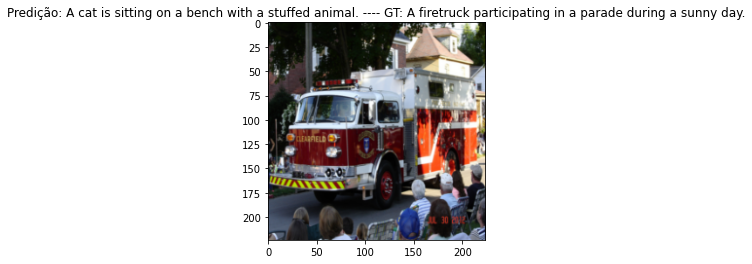

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Época: 0/49 Train Loss: 3.018659 / Train BLEU: 3.4438919563949115 Valid BLEU: 6.060015793496379


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man sitting on a bench with a dog. a man sitting on a bench with a dog.', 'A man is holding a hotdog with ketchup. a man is holding a hotdog.', 'A large airplane is flying in the sky. a large airplane is flying in the sky. a', 'A cat is sitting on a bed with a laptop. a cat is sitting on a bed with a laptop.', 'A man is riding a horse in a field. a man is riding a horse. a man', 'A man is riding a horse in a field. a man is riding a horse. a man', 'A man is riding a horse in a field. a man is riding a horse. a man', 'A man is riding a horse in a field. a man is riding a horse in the snow.', 'A man is standing on a beach with a dog. a dog is sitting on a beach.', 'A giraffe standing next to a tree in a field. a zebra standing in the grass.', 'A giraffe standing next to a tree in a field. a zebra standing next to a tree.', 'A man is riding a horse in the water. a man is riding a horse in the water.', 'A man is holding a hot dog in a field. a man is holding a hotdog.', 'A cat is sitti

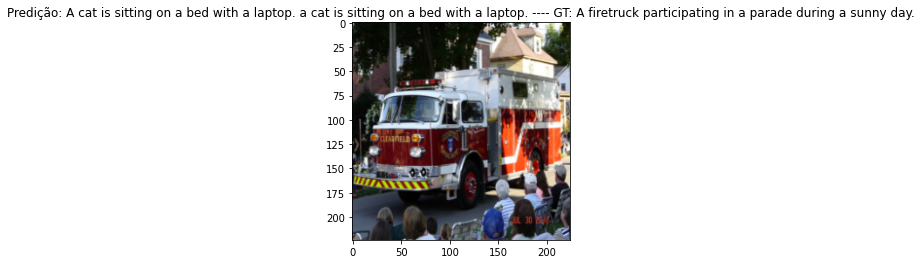

Época: 1/49 Train Loss: 2.848405 / Train BLEU: 4.335140371235489 Valid BLEU: 4.468119959324121


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A cat sitting on top of a laptop computer. a dog is sitting on a desk. a', 'A man is sitting on a bench with a dog. a dog is sitting on a bench.', 'A large white airplane is sitting on the runway. a giraffe standing next to a tree.', 'A cat sitting on top of a laptop. a dog on a bed with a stuffed animal.', 'A man is sitting on a bench with a dog. a dog is sitting on a bench.', 'A man is riding a horse in a field. a giraffe standing next to a tree.', 'A man is sitting on a bench in front of a house. a man is standing next to a horse.', 'A man is sitting on a bench in front of a tree. a dog is sitting on a bench.', 'A large jet airplane flying over a cloudless sky. a large airplane flying in the sky. a', 'A giraffe standing next to a tree in a field. a giraffe standing next to a', 'A giraffe standing next to a tree in a field. a giraffe standing next to a tree', 'A large white bird perched on top of a tree branch. a tree in the middle of a forest.', 'A dog is sitting on a couch with a

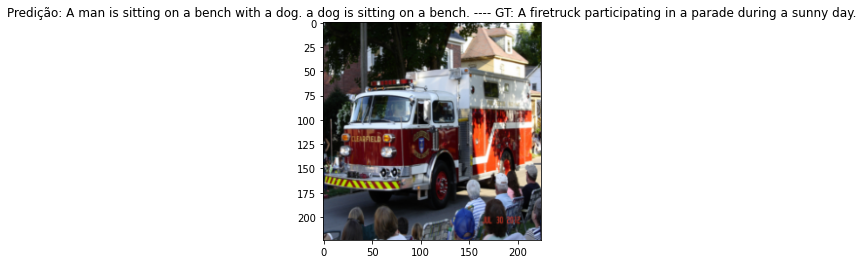

Época: 2/49 Train Loss: 2.758631 / Train BLEU: 4.6802329770358275 Valid BLEU: 7.1044407583410205


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A cat is sitting on a table next to a laptop.', 'A man is riding a horse in a field.', 'A man riding a horse on a beach.', 'A cat is sitting on a laptop computer.', 'A man is riding a horse on a street.', 'A man riding a horse on a beach.', 'A man riding a horse on a street.', 'A cat is sitting on a table next to a laptop.', 'A large white airplane is parked on the runway.', 'A giraffe standing next to a tree in a field.', 'A giraffe is standing in the grass next to a tree.', 'A man riding a skateboard on a beach.', 'A dog is laying on a bed with a stuffed animal.', 'A cat is sitting on a table with a stuffed animal.', 'A cat is sitting on a table next to a computer.', 'A cat is sitting on a table next to a laptop.', 'A cat is sitting on a laptop computer.', 'A man is riding a horse on a beach.', 'A man is riding a horse on a street.', 'A man riding a horse on a beach.', 'A cat is sitting on a table next to a laptop.', 'A cat is sitting on a table next to a computer.', 'A man riding 

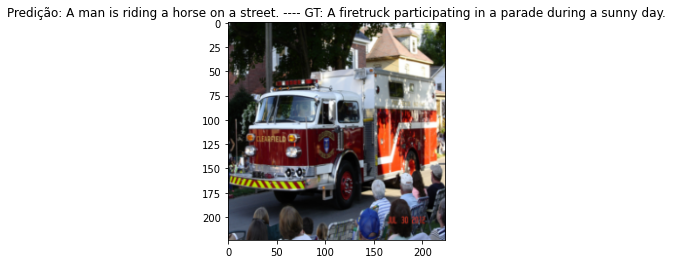

Época: 3/49 Train Loss: 2.696985 / Train BLEU: 5.0309069135712265 Valid BLEU: 8.946149749835838


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A cat sitting on a table with a laptop and a laptop.', 'A man is holding a hot dog with a pickle.', 'A large passenger jet sitting on top of an airport runway.', 'A cat sitting on a desk with a laptop.', 'A man in a red shirt is riding a red motorcycle.', 'A man riding a horse on a beach.', 'A man is riding a horse on a city street.', 'A giraffe standing next to a tree in a field.', 'A man in a blue shirt is riding a white horse.', 'A giraffe standing in a field with a tree in the background.', 'A giraffe standing next to a tree in a forest.', 'A man in a blue shirt is riding a white horse.', 'A woman in a red shirt and a black and white dog.', 'A cat laying on a bed with a stuffed animal.', 'A cat laying on a bed with a stuffed animal.', 'A cat sitting on a chair with a laptop on it.', 'A cat sitting on a desk with a laptop.', 'A man is riding a horse on a beach.', 'A man in a black jacket is riding a horse.', 'A man riding a horse on a beach.', 'A cat sitting on a desk with a lapto

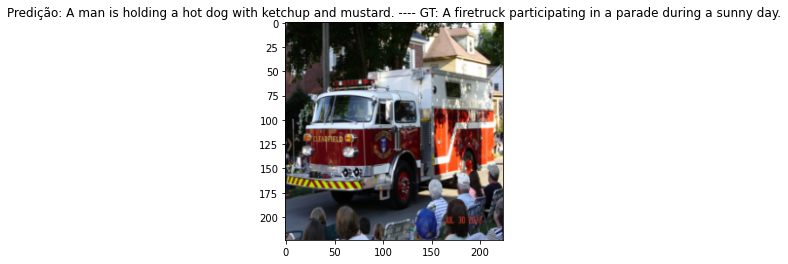

Época: 4/49 Train Loss: 2.651869 / Train BLEU: 5.346514985798357 Valid BLEU: 8.431312763807039


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is holding a hot dog with mustard and mustard.', 'A man and a woman in a blue shirt and a black and white dog on a leash.', 'A man is riding a horse in a field.', 'A cat is sitting on a laptop computer.', 'A man is riding a horse in a field.', 'A man riding a horse in a field.', 'A man is riding a horse in a field.', 'A man is riding a horse in a field.', 'A man is riding a skateboard in the snow.', 'A bird is standing on a tree branch.', 'A giraffe standing in a tree with a tree in the background.', 'A man is riding a skateboard down a street.', 'A man riding a horse in a field.', 'A cat is sitting on a chair with a laptop.', 'A cat is sitting on a chair with a laptop.', 'A man and a woman in a suit and tie on a horse.', 'A cat is sitting on a laptop computer.', 'A man is riding a horse in a field.', 'A man is riding a horse in a field.', 'A man riding a horse in a field.', 'A cat is sitting on a chair with a laptop.', 'A cat is sitting on a desk with a laptop.', 'A giraffe st

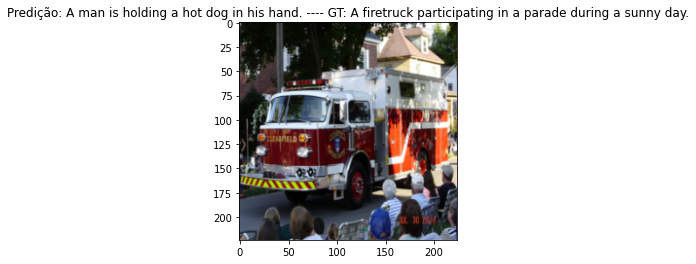

Época: 5/49 Train Loss: 2.616076 / Train BLEU: 5.552008869672144 Valid BLEU: 8.204017681854857


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is holding a hot dog in his hand.', 'A man and woman in a red shirt and a black and white dog.', 'A man riding a horse in a field with a dog.', 'A cat is sitting on a bed with a teddy bear.', 'A red and white bus driving down a street.', 'A red and white fire hydrant is parked in a grassy area.', 'A man riding a horse in a field with a dog.', 'A man riding a horse in a field.', 'A man riding a horse on a beach.', 'A bird perched on a branch of a tree.', 'A giraffe standing next to a tree in a forest.', 'A man is standing on a boat with a dog.', 'A red and white fire hydrant in a grassy area.', 'A cat is sitting on a chair with a laptop.', 'A man is holding a hot dog in his hand.', 'A man is holding a hot dog in his hand.', 'A cat is sitting on a desk with a laptop.', 'A man is riding a horse in the snow.', 'A man riding a horse in a fenced in area.', 'A man riding a horse in a field with a man in the background.', 'A man is holding a hot dog in his hand.', 'A man is riding a ho

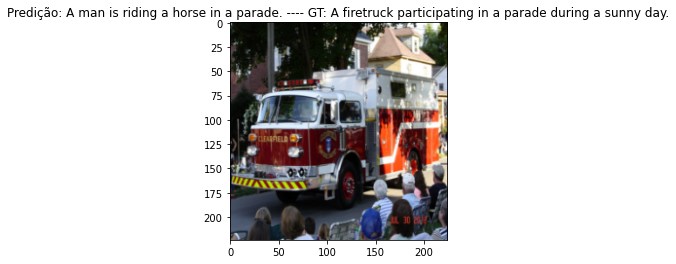

Época: 6/49 Train Loss: 2.584451 / Train BLEU: 5.870048973878388 Valid BLEU: 9.380640921859102


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man holding a hot dog in a bun.', 'A man and a woman are standing next to a horse.', 'A man riding a horse on a dirt road.', 'A cat is sitting on a chair in front of a window.', 'A red and white bus driving down a street.', 'A red and white bus is parked in front of a building.', 'A man and a woman are riding a horse.', 'A man riding a horse on a city street.', 'A man and a dog on a surfboard.', 'A giraffe standing next to a tree in a field.', 'A giraffe standing next to a tree in a forest.', 'A man is riding a horse on a beach.', 'A red and white fire hydrant sitting on a grass field.', 'A cat laying on top of a wooden table.', 'A cat laying on top of a wooden table.', 'A woman is holding a hot dog in her hand.', 'A cat laying on top of a laptop computer.', 'A man riding a horse on a dirt road.', 'A man riding a horse on a city street.', 'A man riding a horse on a dirt road.', 'A cat sitting on top of a wooden table.', 'A man and a woman are riding a horse.', 'A giraffe standing n

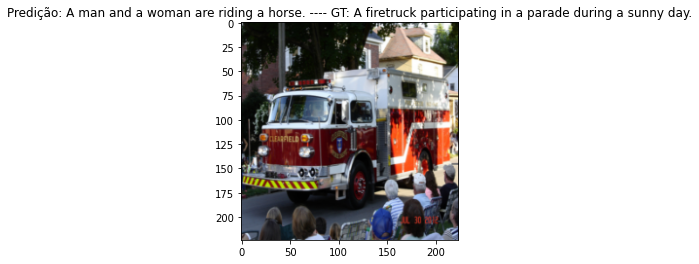

Época: 7/49 Train Loss: 2.557548 / Train BLEU: 5.8569312003227605 Valid BLEU: 11.411718256559249


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A cat sitting on top of a wooden table.', 'A man and a woman sitting on a bench with a dog.', 'A man is riding a horse in a field.', 'A cat is sitting on a chair in a room.', 'A red fire truck parked in front of a building.', 'A red fire hydrant sitting on a street.', 'A man and a woman standing next to a horse.', 'A man and a woman are standing in front of a car.', 'A man riding a horse on a beach.', 'A cat is sitting on a wooden bench.', 'A bird is perched on a branch in the woods.', 'A cat sitting on top of a laptop computer.', 'A red fire hydrant sitting in a grassy field.', 'A cat is sitting on a wooden table.', 'A cat is sitting on a chair in a living room.', 'A man and a woman are sitting on a horse.', 'A cat sitting on top of a laptop computer.', 'A cat sitting on top of a wooden bench.', 'A cat sitting on top of a car.', 'A man riding a horse on a dirt road.', 'A cat sitting on top of a suitcase.', 'A cat sitting on top of a wooden bench.', 'A zebra standing in a grassy fiel

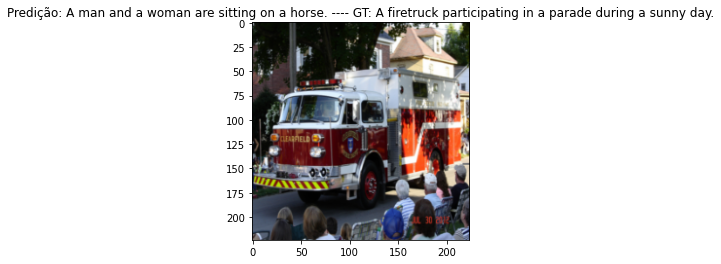

Época: 8/49 Train Loss: 2.533028 / Train BLEU: 6.168882822581161 Valid BLEU: 11.587449288825596


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man holding a hot dog in a bun with mustard and ketchup.', 'A man and woman sitting on a bench with a dog.', 'A man is standing next to a horse in a field.', 'A cat is sitting on a chair in front of a window.', 'A red and white fire truck parked in front of a building.', 'A man riding a horse in a field.', 'A man is standing next to a horse in a field.', 'A man is sitting on a bench with a dog.', 'A man in a blue jacket is flying a kite.', 'A bird perched on a branch in a tree.', 'A giraffe standing next to a tree in a forest.', 'A man is sitting on a boat in the water.', 'A man and a woman are standing in the grass.', 'A man and woman are sitting on a couch with a cat.', 'A cat is sitting on a chair with a remote control.', 'A man and woman are sitting on a horse.', 'A cat is sitting on a laptop computer.', 'A man is sitting on a couch with a cat.', 'A man is riding a horse in a field.', 'A man is riding a horse in a field.', 'A man is sitting on a couch with a cat.', 'A man is st

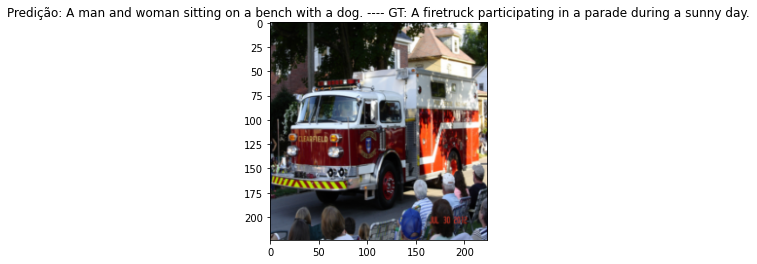

Época: 9/49 Train Loss: 2.511185 / Train BLEU: 6.33126660425257 Valid BLEU: 11.042954198395348


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A hot dog with ketchup and mustard on a bun.', 'A man and a woman are standing in front of a group of people.', 'A man standing next to a horse in a field.', 'A cat is sitting on a laptop computer.', 'A red and white fire truck parked in front of a building.', 'A red and white fire truck parked in front of a fire hydrant.', 'A man standing next to a horse in a field.', 'A man is riding a horse in a crowded street.', 'A large jetliner flying through the air with a blue sky in the background.', 'A black bear standing in a tree with a tree in the background.', 'A giraffe standing next to a tree in a forest.', 'A man is sitting on a boat with a dog.', 'A man riding a horse in a field.', 'A cat sitting on a chair with a stuffed animal.', 'A cat is sitting on a chair.', 'A man and a woman are eating a hot dog.', 'A man is holding a hot dog in his hand.', 'A man is sitting on a couch with a dog.', 'A man is sitting on a bench with a dog.', 'A man riding a horse in a field.', 'A cat sitting 

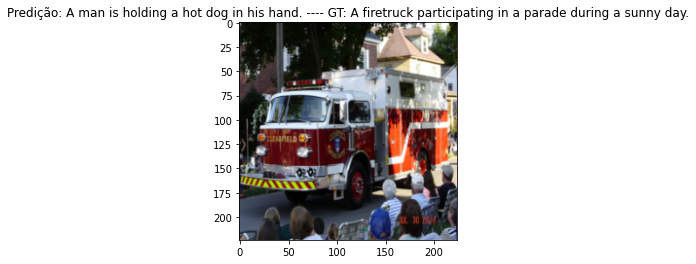

Época: 10/49 Train Loss: 2.491749 / Train BLEU: 6.326609207310991 Valid BLEU: 11.238252033852332


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A hot dog with mustard and ketchup on a bun.', 'A group of people standing around a horse drawn carriage.', 'A man is standing next to a horse in a field.', 'A cat is sitting on a toilet seat in a bathroom.', 'A red fire truck is parked in front of a building.', 'A red and white fire truck parked in front of a building.', 'A man is riding a horse in a field.', 'A man is riding a horse in a field.', 'A man is flying a kite in the air.', 'A bird perched on top of a tree branch.', 'A giraffe standing next to a tree in a grassy area.', 'A cat sitting on top of a laptop computer.', 'A red fire hydrant sitting on top of a grass covered field.', 'A hot dog with mustard and ketchup on a bun.', 'A cat is sitting on a chair with a stuffed animal.', 'A cat sitting on a table next to a laptop.', 'A cat is sitting on a laptop computer.', 'A man is sitting on a bench with a dog.', 'A man is sitting on a bench with a dog.', 'A man is riding a horse in a field.', 'A cat is sitting on a desk next to 

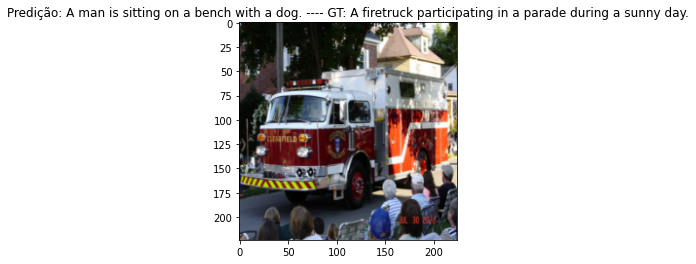

Época: 11/49 Train Loss: 2.474205 / Train BLEU: 6.566997902799535 Valid BLEU: 11.89778124072229


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A hot dog with mustard and ketchup on a bun.', 'A man is holding a hot dog in his hands.', 'A man is standing next to a truck.', 'A cat is sitting on a window sill.', 'A red truck with a red and white awning.', 'A large red truck parked in a grassy field.', 'A man is standing next to a horse.', 'A man is riding a skateboard on a skateboard.', 'A large jetliner flying through a blue sky.', 'A black and white cat sitting on a wooden bench.', 'A giraffe standing next to a tree in a grassy area.', 'A dog is sitting on a couch with a remote control.', 'A dog is catching a frisbee in its mouth.', 'A cat sitting on a wooden table next to a table.', 'A cat is sitting on a wooden table.', 'A cat sitting on a wooden table next to a table.', 'A cat is sitting on a laptop computer.', 'A dog is sitting on a couch with a remote control.', 'A dog is sitting on a bench in front of a window.', 'A man is riding a horse in a field.', 'A cat sitting on a desk next to a computer.', 'A man is standing in 

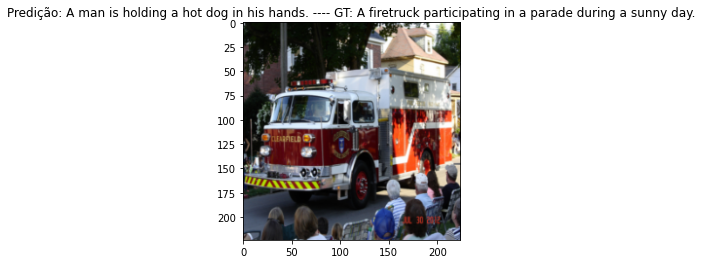

Época: 12/49 Train Loss: 2.457661 / Train BLEU: 6.796173245940407 Valid BLEU: 11.582461595736625


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is eating a hot dog with mustard and ketchup.', 'A man is sitting on a horse in a parade.', 'A man is riding a horse in a field.', 'A cat is laying on a bed with a remote control.', 'A red truck parked on the side of a road.', 'A red truck is parked on the side of the road.', 'A man is riding a horse in a fenced area.', 'A man is riding a horse in a parade.', 'A man is skiing in the snow with a dog.', 'A black bear is standing in the grass.', 'A man is riding a horse in a field.', 'A man is sitting on a boat with a dog.', 'A red fire truck parked in front of a house.', 'A cat sitting on a table next to a table.', 'A cat is sitting on a chair in a room.', 'A man is holding a hot dog in a bun.', 'A cat is sitting on a desk with a laptop.', 'A man is sitting on a bench with a dog.', 'A man is sitting on a bench with a dog.', 'A man is riding a horse in a field.', 'A cat sitting on a desk next to a computer.', 'A cat sitting on a desk next to a computer.', 'A black bear is standing

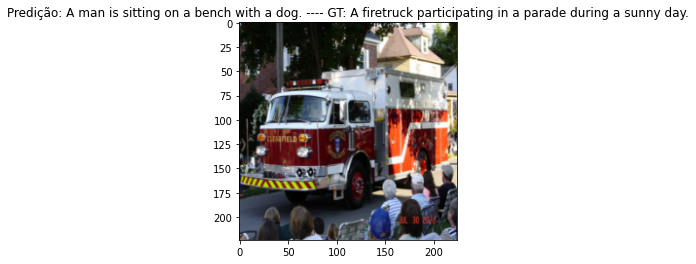

Época: 13/49 Train Loss: 2.442093 / Train BLEU: 6.8543201570358026 Valid BLEU: 11.077281786128585


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man holding a hot dog with mustard and ketchup.', 'A man standing next to a horse in a city.', 'A man standing next to a truck with a dog in the back.', 'A cat sitting on top of a laptop computer.', 'A red fire truck is parked on the street.', 'A truck is parked on the side of the road.', 'A man standing next to a horse in a field.', 'A man standing next to a car with a dog.', 'A man and a dog are on a surfboard.', 'A bird sitting on top of a tree branch.', 'A bird sitting on a branch in a tree.', 'A man sitting on a bench with a dog on his lap.', 'A red fire hydrant sitting next to a tree.', 'A man sitting on a couch with a dog.', 'A cat sitting on top of a wooden table.', 'A man is holding a hot dog in his hand.', 'A cat sitting on top of a laptop computer.', 'A man standing next to a horse in a field.', 'A man standing next to a car with a dog.', 'A man riding a horse in a field.', 'A cat sitting on top of a laptop computer.', 'A man standing next to a horse in a field.', 'A bla

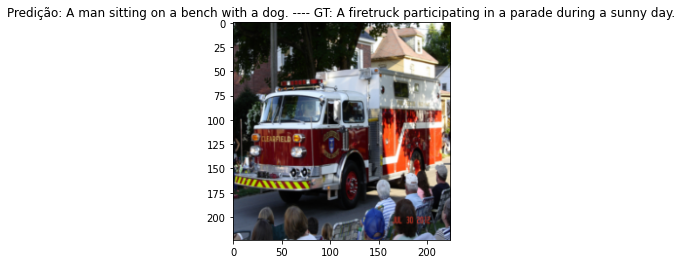

Época: 14/49 Train Loss: 2.427431 / Train BLEU: 6.9867020183281205 Valid BLEU: 13.870449200439323


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A hot dog with ketchup and mustard on it.', 'A group of people standing around a food truck.', 'A man is riding a horse in a field.', 'A cat is sitting on a chair in a room.', 'A red truck parked in front of a building. the back of a truck.', 'A truck is parked on the side of the road.', 'A man is standing next to a horse in a field.', 'A man is riding a motorcycle with a dog on it.', 'A large jetliner flying through a blue sky.', 'A bird is perched on a tree branch.', 'A bird sitting on a branch in a tree.', 'A cat sitting on a blue chair in a room.', 'A red fire hydrant sitting next to a tree.', 'A cat sitting on a chair next to a laptop.', 'A cat is sitting on a chair in a room.', 'A man is holding a hot dog in his hand.', 'A cat is sitting on a laptop computer.', 'A cat sitting on a table next to a laptop computer.', 'A man is sitting on a bench with a dog.', 'A man riding a horse in a field. a crowded field.', 'A cat sitting on a desk next to a computer.', 'A cat sitting on a de

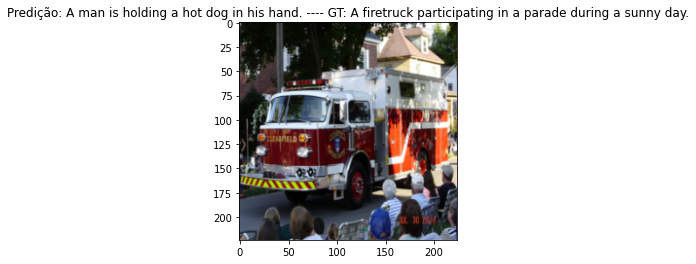

Época: 15/49 Train Loss: 2.413367 / Train BLEU: 7.005829426899001 Valid BLEU: 10.861575467477717


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man holding a hot dog in his hand.', 'A group of people standing around a food truck.', 'A man in a blue shirt riding a horse.', 'A cat is sitting on a toilet seat in a bathroom.', 'A man riding a horse drawn carriage down a street.', 'A man riding a motorcycle with a dog on it.', 'A man is riding a horse in a field.', 'A man is standing in front of a truck.', 'A small airplane flying through the sky with a red sky in the background.', 'A black bear walking through a forest.', 'A giraffe standing next to a tree in a forest.', 'A man in a suit and tie is holding a hot dog.', 'A red truck parked in a field next to a tree.', 'A man in a red shirt and a brown dog sitting on a couch.', 'A cat is sitting on a chair in a room.', 'A man in a red shirt and a red shirt and a black and white cat.', 'A cat is sitting on a laptop computer.', 'A man is sitting on a couch with a cat.', 'A man is riding a motorcycle with a dog on it.', 'A man riding a horse in a field.', 'A man in a suit and tie i

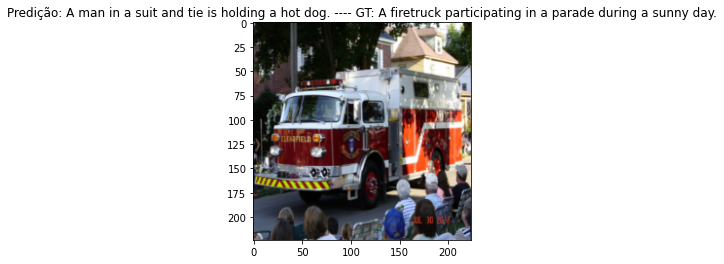

Época: 16/49 Train Loss: 2.400104 / Train BLEU: 7.191783584051779 Valid BLEU: 13.87797748154224


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A hot dog with a lot of toppings on it.', 'A group of people standing around a food truck.', 'A man is riding a horse in a field.', 'A cat is sitting on a toilet seat in a bathroom.', 'A man riding a motorcycle with a dog on it.', 'A man riding a bike with a dog on it.', 'A man is standing next to a horse in a field.', 'A man is riding a horse in a fenced in area.', 'A large jetliner flying through a blue sky.', 'A bird sitting on a tree branch in a forest.', 'A bird sitting on a tree branch in a forest.', 'A man is holding a dog in his lap.', 'A red fire hydrant sitting in the grass.', 'A cat sitting on a chair in a room.', 'A cat sitting on a chair with a remote control.', 'A cat sitting on a table next to a book shelf.', 'A cat is sitting on a desk with a laptop.', 'A cat sitting on a desk next to a computer.', 'A man is walking a dog on a leash.', 'A man riding a horse in a field.', 'A cat sitting on a desk next to a computer.', 'A man is riding a horse in a field.', 'A bear is s

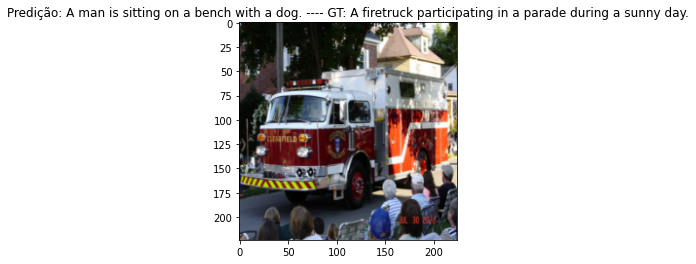

Época: 17/49 Train Loss: 2.387847 / Train BLEU: 7.200899244247145 Valid BLEU: 12.113876875787268


  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

['A man is holding a hot dog in his hand.', 'A man is sitting on a bench with a dog.', 'A man standing next to a green truck.', 'A cat is sitting on a toilet seat in a bathroom.', 'A red truck is parked in front of a building.', 'A man riding a motorcycle down a street next to a car.', 'A man standing next to a truck with a dog on it.', 'A man is standing in front of a white truck.', 'A large jetliner flying through a blue sky.', 'A bird perched on a tree branch in a forest.', 'A bird perched on a tree branch in a forest.', 'A cat sitting on a desk with a laptop and a computer.', 'A red fire hydrant sitting on top of a grass covered field.', 'A man is sitting on a couch with a dog.', 'A woman is holding a cat in her lap.', 'A man is sitting on a couch with a dog.', 'A cat sitting on a desk with a laptop.', 'A man standing next to a truck with a dog on it.', 'A man is sitting on a bench with a dog.', 'A man riding a horse in a field.', 'A man is sitting on a bench with a dog.', 'A giraf

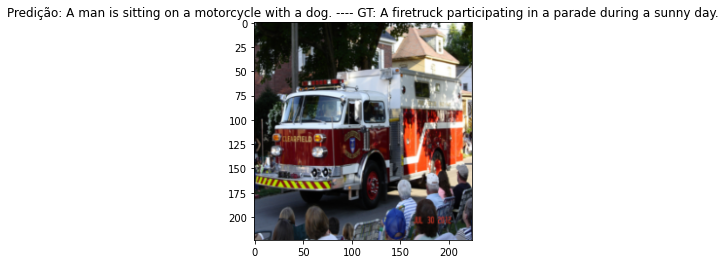

Época: 18/49 Train Loss: 2.375729 / Train BLEU: 7.448800401695982 Valid BLEU: 12.09783605619171


  0%|          | 0/784 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Treinamento
lr = config_wandb["learning_rate"]
compare=float('-inf')
n_epochs = config_wandb["epochs"]


model = CNNT5Model(tokenizer, config_wandb["decoder_pretrained_model"])
model = model.to(device)

#indices = torch.randperm(len(train_dataset))[:500]
#dataset_train = torch.utils.data.Subset(train_dataset, indices)
#train_loader = DataLoader(dataset_train, batch_size=5, shuffle=True, collate_fn = collate_custom, drop_last=True)

train_loader = DataLoader(train_dataset, batch_size=config_wandb["batch_size"], shuffle=True, collate_fn = collate_custom, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config_wandb["batch_size"], collate_fn = collate_custom, drop_last=True)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# referencia: https://towardsdatascience.com/machine-translation-evaluation-with-sacrebleu-and-bertscore-d7fdb0c47eb3
bleu = BLEU()

train_losses = []
val_losses = []
val_bleu_epoch = []
train_bleu_epoch = []

eval_epochs = 1

# Starting wandb
if run_id is not None:
    print(run_id)
    run = wandb.init(project="Image_Captioning", name=f"experiment_CNN_T5_{run}", config=config_wandb, resume=run_id, id=run_id, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

else:
    epoch_init = 0
    run = wandb.init(project="Image_Captioning", name=f"experiment_CNN_T5_{run}", config=config_wandb, resume=True, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

if wandb.run.resumed:
    print("Wandb --resumed")
    wandb.restore(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    checkpoint = torch.load(config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    print(checkpoint['loss'])
    print(checkpoint['epoch'])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch']+1
    loss = checkpoint['loss']

for epoch in  range(epoch_init, config_wandb["epochs"]):
    bleu_list = []
    for batch, (train_inputs, train_targets, train_all_targets) in enumerate(tqdm(train_loader)):
        model.train()
        model.zero_grad()

        train_inputs = train_inputs.to(device)
        train_targets = train_targets.to(device)

        # para o calculo da loss deve aplicar a máscara no start of sequence também? 
        mylabels = train_targets.clone()
        mylabels[mylabels==tokenizer.pad_token_id] = -100

        train_output = model(images = train_inputs, targets=mylabels)
        logits = train_output.logits
        loss = train_output.loss
        train_preds = torch.argmax(logits, dim=-1)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds_sentences = tokenizer.batch_decode(train_preds,  skip_special_tokens=True) #returns a list
        bleu_result = bleu.corpus_score(preds_sentences, list(zip(*train_all_targets)))
        bleu_list.append(bleu_result.score)
        
        wandb.log({"train/batch": batch,
                   "train/batch/loss":loss.item(), 
                   "train/batch/bleu_score":bleu_result.score, 
                   "train/batch/bleu_score_p1":bleu_result.precisions[0],
                   "train/batch/bleu_score_p4":bleu_result.precisions[3]})
    
    train_loss = sum(train_losses)/len(train_losses)
    train_bleu = sum(bleu_list)/len(bleu_list)
    

    with torch.no_grad():
        bleu_list = []
        for val_batch, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
            val_inputs = val_inputs.to(device)
            #val_targets = val_targets.to(device)

            model.eval()
    
            decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)

            #val_labels = torch.cat([decoded_ids,val_targets[:,:-1]], dim=-1)

            for step in range(config_wandb["max_seq_length"]):
                output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
                #print(f"logits.shape: {output_val.logits.shape}")
                val_logits = output_val.logits
                next_token_logits = val_logits[:, -1, :]
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
                #print(f"decoded_ids batch: {decoded_ids}")

                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
                    break

            #loss_v = nn.functional.cross_entropy(val_logits.contiguous().view(-1, val_logits.shape[-1]), val_labels.view(-1), reduction='mean', ignore_index=0)
            #val_losses.append(loss_v)
            val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
            print(val_preds_sentences) 
            bleu_result = bleu.corpus_score(val_preds_sentences, list(zip(*val_all_targets)))
            bleu_list.append(bleu_result.score)

            wandb.log({"val/batch": val_batch,
                    "val/batch/bleu_score":bleu_result.score, 
                    "val/batch/bleu_score_p1":bleu_result.precisions[0],
                    "val/batch/bleu_score_p4":bleu_result.precisions[3]})
            
        #val_loss = sum(val_losses)/len(val_losses)
        val_bleu = sum(bleu_list)/len(bleu_list)

        if val_bleu>compare:
                compare=val_bleu
                torch.save(model, config_wandb["path_save_model"])
    
    if epoch % config_wandb["eval_epochs"] == 0:
        plt.figure()
        plt.imshow(unorm(val_inputs[0].cpu()).permute(1,2,0))
        plt.title("Predição: "+str(val_preds_sentences[0] + " ---- GT: " +str(val_all_targets[0][0])))
        plt.show()
        plt.pause(0.05)

    wandb.log({"epoch": epoch, 
                "train/epoch/loss": train_loss,
                "train/epoch/bleu_score": train_bleu, 
                "val/epoch/bleu_score": val_bleu})

    torch.save({ # Save our checkpoint loc
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, config_wandb["path_save_checkpoints"]+config_wandb["checkpoint_folder_name"])
    wandb.save() # saves checkpoint to wandb

    print(f'Época: {epoch:d}/{n_epochs - 1:d} Train Loss: {train_loss:.6f} / Train BLEU: {train_bleu} Valid BLEU: {val_bleu}')

In [ ]:
wandb.finish()

# Avaliação

In [ ]:
model = torch.load(config_wandb["path_save_model"])
run_id = '22hb0dnv'

In [ ]:
run = wandb.init(project="Image_Captioning", name=f"experiment_CNN_T5_{run}", config=config_wandb, resume=run_id, id=run_id, settings=wandb.Settings(start_method="thread"), reinit=True, dir=os.getenv("WANDB_DIR", config_wandb["path_save_checkpoints"]))

val_loader = DataLoader(val_dataset, batch_size=1, collate_fn = collate_custom)
columns = ["id", "image", "predicted", "captions (GT)", "BLEU", "BLEU-1", "BLEU-4"]
mytable = wandb.Table(columns=columns)

bleu = BLEU()

with torch.no_grad():
    for idx, (val_inputs, val_targets, val_all_targets) in enumerate(tqdm(val_loader)):
        model.eval()
        val_inputs = val_inputs.to(device)
        decoded_ids = torch.full((val_inputs.shape[0], 1),
                            model.decoder_start_token_id,
                            dtype=torch.long).to(val_inputs.device)
            
        for step in range(32):
            output_val =  model(images =  val_inputs, decoder_ids= decoded_ids)
                
            #print(f"logits.shape: {output_val.logits.shape}")
            val_logits = output_val.logits
            next_token_logits = val_logits[:, -1, :]
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)
            #print(f"decoded_ids batch: {decoded_ids}")

            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], model.eos_token_id).all():
                break


        
        val_preds_sentences = tokenizer.batch_decode(decoded_ids,  skip_special_tokens=True)
        bleu_result = bleu.corpus_score(val_preds_sentences, val_all_targets)
        #unorm(val_inputs.squeeze().cpu()).permute(1,2,0)
        mytable.add_data(idx, wandb.Image(unorm(val_inputs.squeeze().cpu()).permute(1,2,0).numpy()), val_preds_sentences, val_all_targets[0], bleu_result.score, bleu_result.precisions[0], bleu_result.precisions[3])

       
wandb.log({f"architecture_experiment_{run_id}": mytable})


  0%|          | 0/1052 [00:00<?, ?it/s]

In [ ]:
wandb.finish()

# Backup